In [1]:

import ROOT as rt
import csv
import re
import sys
import collections
import os

from collections import OrderedDict
import uproot
import pandas as pd
import math
import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
sys.path.append('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/python/')
from helper import make_datacard_2sig, make_datacard_2tag, weight_calc
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaR, deltaPhi

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0


print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
fpath =OrderedDict()
tree = OrderedDict()

start_t = time.time()
data_year = 2022


version = 'v5' # CA 0.4
# version = 'v6' # CA 0.6
data_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19/Data2022/{}/normalized/'.format(version)
signal_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19/MC_Summer22EE/v1/sixie/{}/normalized/'.format(version)
lumi = 23.02*1000

fpath['data'] = data_path + 'DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi.root'
fpath['signal'] = signal_path + 'ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted.root'

NEvents = {}
for k,v in fpath.items():
    root_dir = uproot.open(v)
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    print(v)
    print("Events: ", NEvents[k])
    
for k, T in tree.items():
    branch_names = T.keys()

/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19/Data2022/v5/normalized/DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi.root
Events:  15508012.0
/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19/MC_Summer22EE/v1/sixie/v5/normalized/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted.root
Events:  42882668.0


In [3]:
def L1_trg(cscClusterR, cscClusterZ, cscClusterSize):  
    first_in_ME11 = np.logical_and(np.logical_and(np.logical_and(cscClusterR>100, cscClusterR<275), np.abs(cscClusterZ)>580), np.abs(cscClusterZ)<632) 
    first_in_ME12 = np.logical_and(np.logical_and(np.logical_and(cscClusterR>275, cscClusterR<465), np.abs(cscClusterZ)>668), np.abs(cscClusterZ)<724)
    first_in_ME13 = np.logical_and(np.logical_and(np.logical_and(cscClusterR>505, cscClusterR<700), np.abs(cscClusterZ)>668), np.abs(cscClusterZ)<724)
    first_in_ME21 = np.logical_and(np.logical_and(np.logical_and(cscClusterR>139, cscClusterR<345), np.abs(cscClusterZ)>789), np.abs(cscClusterZ)<850)
    first_in_ME22 = np.logical_and(np.logical_and(np.logical_and(cscClusterR>357, cscClusterR<700), np.abs(cscClusterZ)>791), np.abs(cscClusterZ)<850)
    first_in_ME31 = np.logical_and(np.logical_and(np.logical_and(cscClusterR>160, cscClusterR<345), np.abs(cscClusterZ)>915), np.abs(cscClusterZ)<970)
    first_in_ME32 = np.logical_and(np.logical_and(np.logical_and(cscClusterR>357, cscClusterR<700), np.abs(cscClusterZ)>911), np.abs(cscClusterZ)<970)
    first_in_ME41 = np.logical_and(np.logical_and(np.logical_and(cscClusterR>178, cscClusterR<345), np.abs(cscClusterZ)>1002), np.abs(cscClusterZ)<1063)
    first_in_ME42 = np.logical_and(np.logical_and(np.logical_and(cscClusterR>357, cscClusterR<700), np.abs(cscClusterZ)>1002), np.abs(cscClusterZ)<1063)
    
    first_in_plateau_ME11 = np.logical_and(first_in_ME11, cscClusterSize>=500)
    first_in_plateau_ME21 = np.logical_and(first_in_ME21, cscClusterSize>=500)
    first_in_plateau_ME31 = np.logical_and(first_in_ME31, cscClusterSize>=500)
    first_in_plateau_ME41 = np.logical_and(first_in_ME41, cscClusterSize>=500)

    first_in_plateau_ME12 = np.logical_and(first_in_ME12, cscClusterSize>=200)
    first_in_plateau_ME13 = np.logical_and(first_in_ME13, cscClusterSize>=200)
    first_in_plateau_ME22 = np.logical_and(first_in_ME22, cscClusterSize>=200)
    first_in_plateau_ME32 = np.logical_and(first_in_ME32, cscClusterSize>=200)
    first_in_plateau_ME42 = np.logical_and(first_in_ME42, cscClusterSize>=200)
    
    first_in_plateau = first_in_plateau_ME11 | first_in_plateau_ME12 | first_in_plateau_ME13 | first_in_plateau_ME21 | first_in_plateau_ME22 | \
    first_in_plateau_ME31 | first_in_plateau_ME32 | first_in_plateau_ME41 | first_in_plateau_ME42
    return first_in_plateau

# Selections

In [6]:
sel_ev = {}
weight = {}
met = {}
nCscClusters = {}
nDtClusters = {}

#DT

dtClusterMuonVetoPt = {}
dtClusterJetVetoPt = {}
dtClusterPhi = {}
dtClusterEta = {}
dtClusterSize = {}
dtClusterTime = {}
dtClusterNStation = {}
dtClusterMaxStation = {}
dtClusterNHitStation1 = {}
dtCluster_match_MB1hits_0p5 = {}
dtCluster_match_MB1hits_0p4 = {}
#CSC

cscClusterMuonVetoPt = {}
cscClusterJetVetoPt = {}
cscClusterPhi = {}
cscClusterEta = {}
cscClusterSize = {}
cscClusterTimeWeighted = {}
cscClusterTimeSpreadWeighted = {}
cscClusterTime = {}
cscClusterTimeSpread = {}
cscClusterNStation = {}
cscClusterMaxChamber = {}
cscClusterAvgStation = {}
cscClusterMaxStation = {}
cscClusterMe11Ratio = {}
cscClusterMe12Ratio  = {}
dEta = {}
dPhi = {}
dR = {}
runNum = {}
metFilters = {}


for k, T in tree.items():
    
    ########### SELECTION: CLUSTERS ############

    #CSC
    sel_trgCluster = L1_trg((T.array('cscRechitClusterX')**2+T.array('cscRechitClusterY')**2)**0.5, T.array('cscRechitClusterZ'), T.array('cscRechitClusterSize'))
    sel_csccluster = sel_trgCluster
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitClusterTimeWeighted')<12.5)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitClusterTimeWeighted')>-5)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitClusterTimeSpreadWeightedAll')<20)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitClusterJetVetoPt')<10)





    sel_dtcluster = np.abs(T.array('dtRechitClusterSize')) > 50
    sel_dtcluster = np.logical_and(sel_dtcluster, T.array('dtRechitCluster_match_RPCBx_dPhi0p5')==0)

    sel_dtcluster = np.logical_and(sel_dtcluster, T.array('dtRechitCluster_match_RPChits_dPhi0p5')>0)

    sel_dtcluster = np.logical_and(sel_dtcluster, T.array('dtRechitClusterJetVetoPt')<10)
    sel_dtcluster = np.logical_and(sel_dtcluster, T.array('dtRechitClusterNHitStation1')==0)



    if not 'data' in k:
        sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster_match_gLLP'))
        sel_dtcluster = np.logical_and(sel_dtcluster, T.array('dtRechitCluster_match_gLLP'))
    

    ########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()    
    #HLT_CaloMET60_DTCluster50 = hlt[:,562]
    #HLT_CaloMET60_DTClusterNoMB1S50 = hlt[:,563]
    #HLT_L1MET_DTCluster50 = hlt[:,564]
    #HLT_L1MET_DTClusterNoMB1S50 = hlt[:,565]
    HLT_CscCluster_Loose = hlt[:,566]
#     HLT_CscCluster_Medium = hlt[:,567]
#     HLT_CscCluster_Tight = hlt[:,568]
    HLT_L1CSCShower_DTCluster50 = hlt[:,569]
    HLT_L1CSCShower_DTCluster75 = hlt[:,570]

#     sel_ev[k] = np.logical_or(HLT_L1CSCShower_DTCluster50, HLTDecision[:,188])

    sel_ev[k] = HLT_L1CSCShower_DTCluster50

    sel_ev[k] = np.logical_and(sel_ev[k], sel_csccluster.sum()>0)
    sel_ev[k] = np.logical_and(sel_ev[k], sel_dtcluster.sum()>0)
#     sel_ev[k] = np.logical_and(sel_csccluster.sum()>0, sel_dtcluster.sum()>0)

    if 'data' in k:
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('runNum')>=360019)
    
    met[k] = T.array("met")[sel_ev[k]]

#     metFilters[k] = T.array("metFilters")[sel_ev[k]]

    runNum[k] = T.array('runNum')[sel_ev[k]]
    nCscClusters[k] = sel_csccluster.sum()[sel_ev[k]]
    nDtClusters[k] = sel_dtcluster.sum()[sel_ev[k]]
    weight[k] = T.array('weight')[sel_ev[k]] * lumi
    if 'data' in k:weight[k] = T.array('weight')[sel_ev[k]]*0.0 + 1
########### BRANCHES ############

    #DT
    dtClusterMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterJetVetoPt[k] = T.array('dtRechitClusterJetVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterPhi[k] = T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterEta[k] = T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterSize[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterTime[k] =  T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterNStation[k] =  T.array('dtRechitClusterNStation10')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterMaxStation[k] = T.array('dtRechitClusterMaxStation')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterNHitStation1[k] = T.array('dtRechitClusterNHitStation1')[sel_dtcluster][sel_ev[k]][:,:]
    dtCluster_match_MB1hits_0p5[k] = T.array('dtRechitCluster_match_MB1hits_0p5')[sel_dtcluster][sel_ev[k]][:,:]
    dtCluster_match_MB1hits_0p4[k] = T.array('dtRechitCluster_match_MB1hits_0p4')[sel_dtcluster][sel_ev[k]][:,:]

    #CSC
    cscClusterMuonVetoPt[k] = T.array('cscRechitClusterMuonVetoPt')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterJetVetoPt[k] = T.array('cscRechitClusterJetVetoPt')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterPhi[k] = T.array('cscRechitClusterPhi')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterEta[k] = T.array('cscRechitClusterEta')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterSize[k] =  T.array('cscRechitClusterSize')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTimeWeighted[k] =  T.array('cscRechitClusterTimeWeighted')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTimeSpreadWeighted[k] =  T.array('cscRechitClusterTimeSpreadWeightedAll')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTime[k] =  T.array('cscRechitClusterTime')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTimeSpread[k] =  T.array('cscRechitClusterTimeSpread')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNStation[k] =  T.array('cscRechitClusterNStation10')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterMaxChamber[k] =  T.array('cscRechitClusterMaxChamber')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterAvgStation[k] =  T.array('cscRechitClusterAvgStation10')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterMaxStation[k] =  T.array('cscRechitClusterMaxStation')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterMe11Ratio[k] =  ((T.array('cscRechitClusterNRechitChamberPlus11') + T.array('cscRechitClusterNRechitChamberMinus11'))/T.array('cscRechitClusterSize'))[sel_csccluster][sel_ev[k]][:,:]
    cscClusterMe12Ratio[k] =  ((T.array('cscRechitClusterNRechitChamberPlus12') + T.array('cscRechitClusterNRechitChamberMinus12'))/T.array('cscRechitClusterSize'))[sel_csccluster][sel_ev[k]][:,:]



    
    dEta[k] = cscClusterEta[k][:,0]-dtClusterEta[k][:,0]
    dPhi[k] = deltaPhi(cscClusterPhi[k][:,0], dtClusterPhi[k][:,0])
    dR[k] = deltaR(cscClusterEta[k][:,0],cscClusterPhi[k][:,0], dtClusterEta[k][:,0], dtClusterPhi[k][:,0])
    


# event level

data 197.0 0.3448276
signal 633.6937605142593 0.894084


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


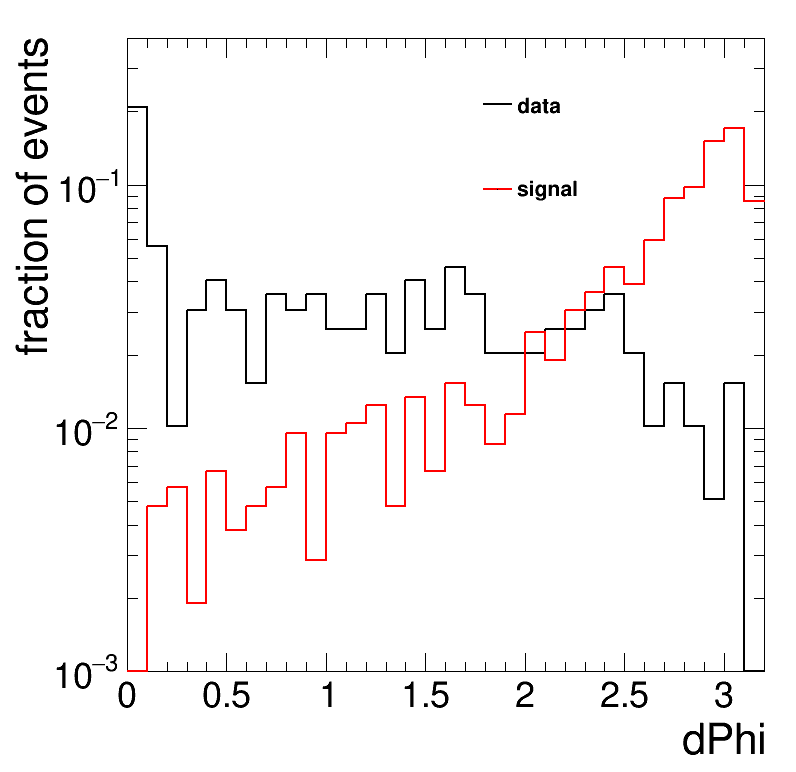

In [21]:
var = [dEta, dPhi, dR, nCscClusters, nDtClusters, met, runNum]
xaxis = ['dEta', 'dPhi', 'dR', 'nCscCluster', 'nDtCluster', 'met', 'runNum']

bins = [ [32,-5,5], [32,0,3.2], [32,0,5], [5,0,5],[5,0,5],[30,0,300], [2741,360019, 362760]]


for index in range(len(var)):
    if not index == 1:continue
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.6,0.7,0.80,0.92)

    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}

    for i, k in enumerate(weight.keys()):
#         if not k == 'data':continue
        h[k] = create_TH1D(var[index][k], axis_title = [xaxis[index], 'fraction of events'], binning = bins[index],weights = weight[k])
        print(k, h[k].Integral(), np.sum(weight[k][np.abs(var[index][k])>1.5])/np.sum(weight[k]))
        if k == 'data':leg.AddEntry(h[k],k)
        else: leg.AddEntry(h[k],k )
        h[k].SetLineColor(std_color_list[i])
        if 'signal' in k:h[k].Scale(0.01)
        if h[k].Integral()>0:h[k].Scale(1./h[k].Integral())
#         if index == 0: h[k].SetMaximum(0.2)
#         elif index ==1 or index == 2:h[k].SetMaximum(0.4)
#         else: h[k].SetMaximum(1.3)
        h[k].SetMinimum(1e-3)

        h[k].SetMaximum(4e-1)

        h[k].Draw('hist same')
    leg.Draw()
    c.SetLogy()
    c.SetRightMargin(0.04)

    c.Draw()






# Csc cluster

data 305.0 0.0
signal 866.0 0.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


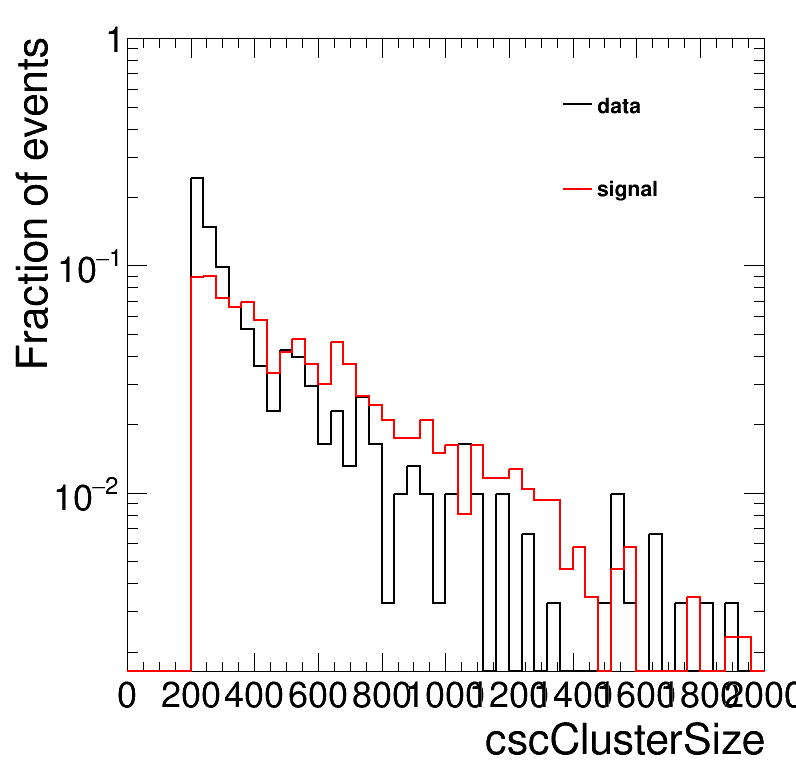

In [14]:

var = [cscClusterMuonVetoPt, cscClusterJetVetoPt, cscClusterPhi, cscClusterEta, cscClusterSize, cscClusterNStation, \
       cscClusterMaxChamber, cscClusterAvgStation, cscClusterMaxStation, cscClusterMe11Ratio, cscClusterMe12Ratio]
name = ['cscClusterMuonVetoPt', 'cscClusterJetVetoPt', 'cscClusterPhi', 'cscClusterEta', 'cscClusterSize', 'cscClusterNStation', \
       'cscClusterMaxChamber', 'cscClusterAvgStation', 'cscClusterMaxStation', 'cscClusterMe11Ratio','cscClusterMe12Ratio']
xaxis = ['cscClusterMuonVetoPt', 'cscClusterJetVetoPt', 'cscClusterPhi', 'cscClusterEta', 'cscClusterSize', 'cscClusterNStation', \
       'cscClusterMaxChamber', 'cscClusterAvgStation', 'cscClusterMaxStation', 'cscClusterMe11Ratio','cscClusterMe12Ratio']

bins = [[50,0,50],[50,0,50],[50,0,3.2],[50,0.8,2.5],[50,0,2000],[5,0,5],[50,0,50],[50,0,5],[50,0,5], [50,0,1],[50,0,1]]


for index in range(len(var)):
    if not index == 4:continue
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.7,0.7,0.90,0.92)

#     leg = rt.TLegend(0.5,0.56,0.75,0.92)

    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}

    for i, k in enumerate(weight.keys()):

        cond = np.abs(cscClusterSize[k][:,0])>1000
        cond = np.abs(cscClusterEta[k][:,0])>1.6

        cond = np.abs(cscClusterEta[k][:,0])<1.2
        cond = np.abs(dPhi[k])>-0.5
        cond = np.logical_and(cond, dtClusterSize[k][:,0]<100)
#         cond = np.logical_and(np.abs(cscClusterEta[k][:,0])<1.6, np.abs(cscClusterEta[k][:,0])>1.2)
        #0.9 1.2
        #1.2 1.6
#         cond = np.logical_and(cond, np.abs(dPhi[k])>1.5)
#         cond = np.logical_and(cond, np.abs(cscClusterSize[k][:,0])>300)
        h[k] = create_TH1D(np.abs(var[index][k][:,0][cond]), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])

        print(k, h[k].Integral(), np.sum(weight[k][np.abs(var[index][k][:,0])==0])/np.sum(weight[k]))

        leg.AddEntry(h[k],k)

        h[k].SetLineColor(std_color_list[i])
        if h[k].Integral()>0:h[k].Scale(1./h[k].Integral())
        h[k].SetMaximum(1)
        h[k].Draw('hist same')
        
    leg.Draw()
    c.SetLogy()
    c.SetRightMargin(0.04)


    c.Draw()


# DT Cluster

data
data 93.0
data 0.23152709
signal
signal 263.38463258743286
signal 0.57490456


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


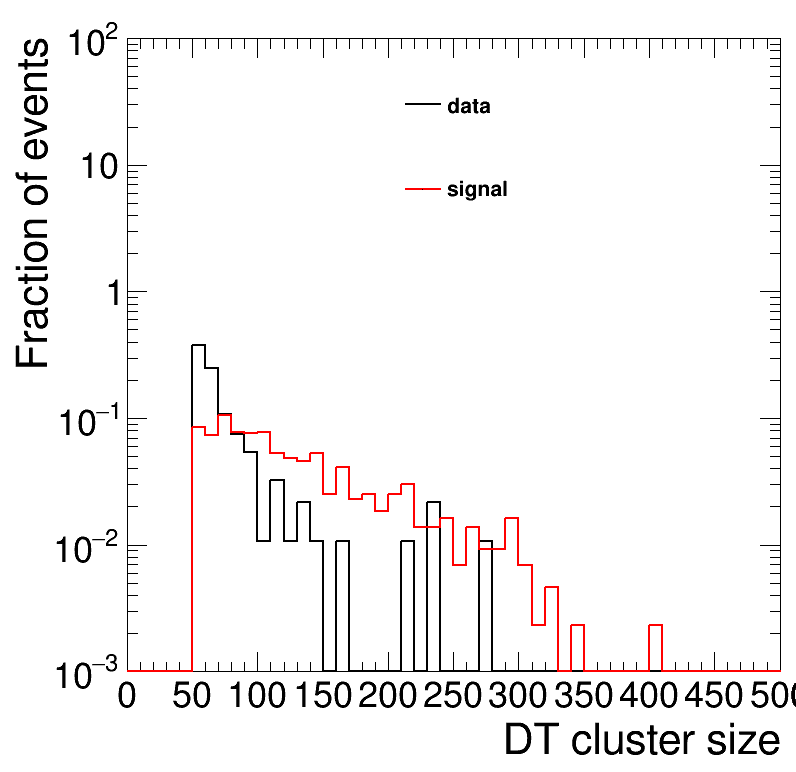

In [20]:
var = [dtClusterJetVetoPt, dtClusterMuonVetoPt, dtClusterPhi, dtClusterEta, dtClusterSize,\
        dtClusterTime, dtClusterNStation, dtClusterMaxStation, dtClusterNHitStation1]
name = ['dtClusterJetVetoPt', 'dtClusterMuonVetoPt', 'dtClusterPhi', 'dtClusterEta', 'dtClusterSize', \
               'dtClusterTime',  'dtClusterNStation', 'dtClusterMaxStation', 'dtClusterNHitStation1']

xaxis = ['jet veto p_{T} [GeV]', 'muon veto p_{T} [GeV]', 'DT cluster #phi', 'DT cluster #eta', 'DT cluster size', \
         'dt cluster BX', 'DT cluster N_{stations}', 'DT cluster max station', 'DT cluster Nhits MB1']

bins = [ [50,0,100],[10,0,100], [25,0,3.2], [50,0,1.1], [50,0,500], [20,-10,10],[5,0,5],[5,0,5],[50,0,50]]


for index in range(len(var)):
    if not index == 4:continue
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.5,0.7,0.75,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}
    for i, k in enumerate(weight.keys()):
        print(k)
#         if k == 'data':sel_dtcluster =  dtClusterSize[k]<80
#         else: sel_dtcluster = dtClusterSize[k]>=50
#         sel_dtcluster = np.logical_and(sel_dtcluster, dtClusterTime[k] == 0)
#         sel_dtcluster = np.logical_and(sel_dtcluster, dtClusterJetVetoPt[k] < 10)
#         sel_dtcluster = np.logical_and(sel_dtcluster, dtClusterMuonVetoPt[k] < 10)

        cond = np.abs(dPhi[k])>0.5
        cond = np.logical_and(cond, cscClusterSize[k][:,0]<300)
        if 'data' in k:
            h[k] = create_TH1D(np.abs(var[index][k][:,0][cond]), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
        else: h[k] = create_TH1D(np.abs(var[index][k][:,0][cond]), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index],weights=weight[k][cond])
        print(k, h[k].Integral())
        print(k, np.sum(weight[k][np.abs(var[index][k][:,0])>100])/np.sum(weight[k]))


        if h[k].Integral()>0:h[k].Scale(1./h[k].Integral())
        h[k].SetMaximum(100)
        h[k].SetMinimum(0.001)
        h[k].SetLineColor(std_color_list[i])
        h[k].Draw('hist same')

        if k == 'data':leg.AddEntry(h[k],k)
        else: leg.AddEntry(h[k],k)
    leg.Draw()

    c.SetLogy()
    c.Draw()
#     plot_path = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots'+v2+'/'
#     if not os.path.exists(plot_path):os.makedirs(plot_path)
#     c.SaveAs(plot_path+'dtdt_'+name[index]+".png")
#     c.SaveAs(plot_path+'dtdt_'+name[index]+".pdf")
#     c.SaveAs(plot_path+'dtdt_'+name[index]+".C")


# 2d plots

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


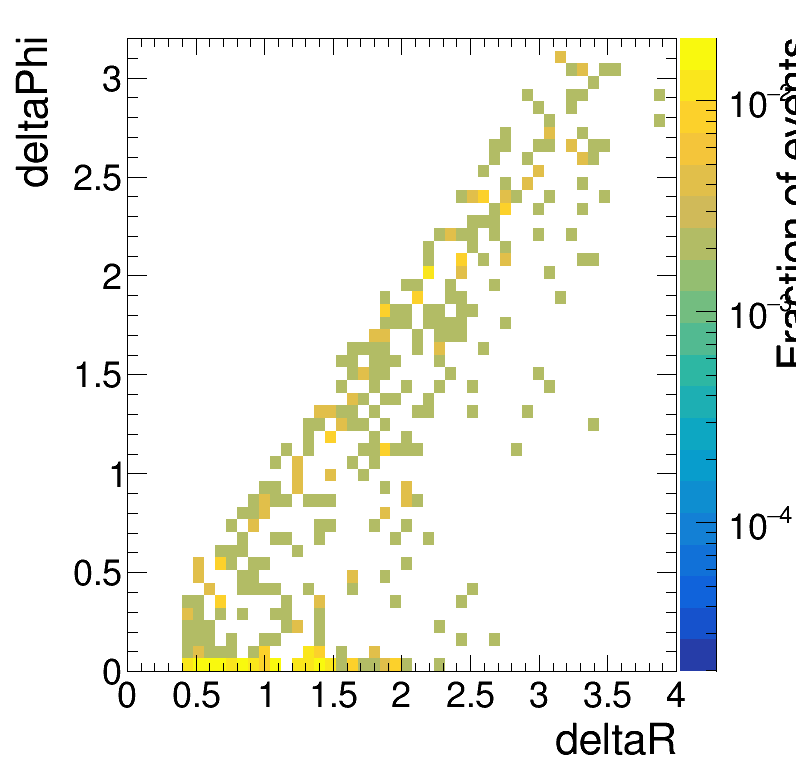

In [9]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.7,0.7,0.90,0.92)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h = {}

k = 'data'
# k='signal'
h[k] = create_TH2D(np.column_stack((np.abs(cscClusterEta[k][:,0]), np.abs(cscClusterPhi[k][:,0]))), axis_title = ['cscCluster eta', 'cscCluster phi', 'Fraction of events'], binning = [20,0.8,2.4,20,0,3.2])
# h[k] = create_TH2D(np.column_stack((np.abs(dtClusterEta[k][:,0]), np.abs(dtClusterPhi[k][:,0]))), axis_title = ['dtCluster eta', 'dtCluster phi', 'Fraction of events'], binning = [20,0,1.2,20,0,3.2])
h[k] = create_TH2D(np.column_stack((np.abs(cscClusterMaxStation[k][:,0]), np.abs(dtClusterMaxStation[k][:,0]))), \
                   axis_title = ['cscCluster max station', 'dtCluster max station', 'Fraction of events'], binning = [5,0,5,5,0,5])

# h[k] = create_TH2D(np.column_stack((np.abs(cscClusterNStation[k][:,0]), np.abs(dtClusterNStation[k][:,0]))), \
#                    axis_title = ['cscCluster Nstation', 'dtCluster Nstation', 'Fraction of events'], binning = [5,0,5,5,0,5])


# h[k] = create_TH2D(np.column_stack((np.abs(cscClusterPhi[k][:,0]), np.abs(dtClusterPhi[k][:,0]))), \
#                    axis_title = ['cscCluster phi', 'dtCluster phi', 'Fraction of events'], binning = [20,0,3.2,20,0,3.2])

# h[k] = create_TH2D(np.column_stack((np.abs(cscClusterEta[k][:,0]), np.abs(dtClusterEta[k][:,0]))), \
#                    axis_title = ['cscCluster eta', 'dtCluster eta', 'Fraction of events'], binning = [50,0,2.5,50,0,1])
h[k] = create_TH2D(np.column_stack((np.abs(dR[k]), np.abs(dPhi[k]))), \
                   axis_title = ['deltaR','deltaPhi', 'Fraction of events'], binning = [50,0,4,50,0,3.2])



# print(k, np.sum(weight[k][np.abs(var[index][k][:,0])==0])/np.sum(weight[k]))
leg.AddEntry(h[k],k)

# h[k].SetLineColor(std_color_list[i])
if h[k].Integral()>0:h[k].Scale(1./h[k].Integral())
# h[k].SetMaximum(2)
h[k].Draw('colz')

# leg.Draw()
c.SetLogz()
c.SetRightMargin(0.15)


c.Draw()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


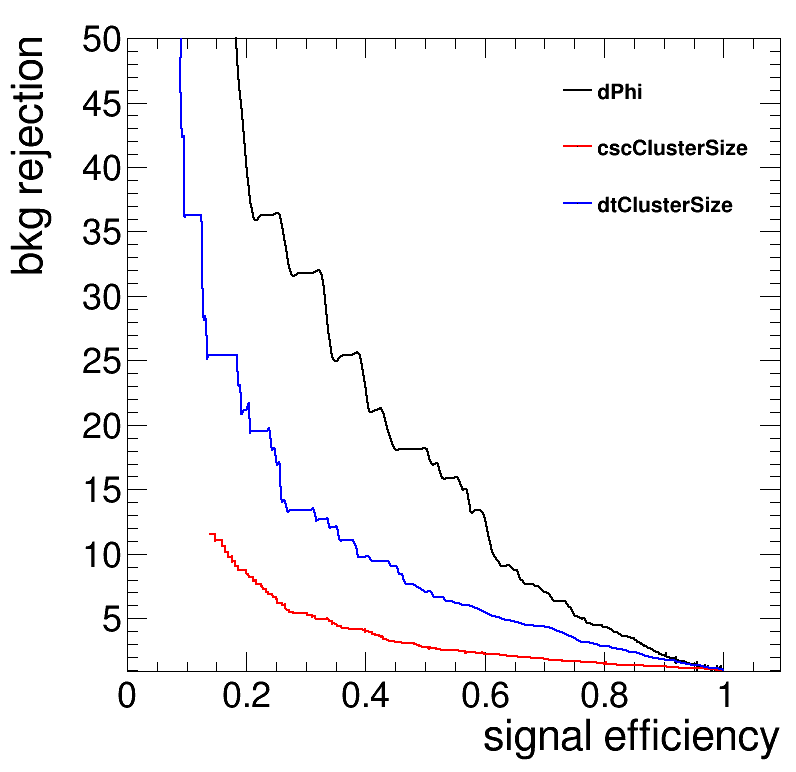

In [23]:
# ROC curve
bkg_eff = {}
sig_eff = {}
variables = [dPhi, cscClusterSize, dtClusterSize]

names = ['dPhi', 'cscClusterSize', 'dtClusterSize']

for i, var in enumerate(variables):
    bkg_eff[names[i]] = []
    sig_eff[names[i]] = []
    if i == 0:threshold = np.arange(0,3.2,0.01)
    else: threshold = np.arange(0,1000,1)
    for th in threshold:
        denom = np.abs(dPhi['data']) > 0.5
        if i == 0:cond = np.abs(var['data']) > th
        else:cond = np.abs(var['data'][:,0]) > th
        bkg_eff[names[i]].append(np.sum(weight['data'][np.logical_and(denom,cond)])/np.sum(weight['data'][denom]))
        
        denom = np.abs(dPhi['signal']) > 0.5
        if i == 0:cond = np.abs(var['signal']) > th
        else:cond = np.abs(var['signal'][:,0]) > th
        sig_eff[names[i]].append(np.sum(weight['signal'][[np.logical_and(denom,cond)]])/np.sum(weight['signal'][denom]))

    sig_eff[names[i]] = np.array(sig_eff[names[i]])
    bkg_eff[names[i]] = np.array(bkg_eff[names[i]])
    sig_eff[names[i]] = sig_eff[names[i]][bkg_eff[names[i]]>0]
    bkg_eff[names[i]] = bkg_eff[names[i]][bkg_eff[names[i]]>0]


c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.7,0.7,0.90,0.92)

#     leg = rt.TLegend(0.5,0.56,0.75,0.92)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
graph = {}
for i, v in enumerate(names):
    graph[v] = create_TGraph(sig_eff[v], 1/bkg_eff[v], axis_title= ['signal efficiency', 'bkg rejection'])
    graph[v].SetLineWidth(2)
    graph[v].SetLineColor(std_color_list[i])
    leg.AddEntry(graph[v], v)
    graph[v].SetMaximum(50)
    graph[v].Draw('ac' if i == 0 else 'c same')
leg.Draw()
c.Draw()



# find the set of thresholds with best s/sqrt(b)

In [26]:

variables = [dPhi, cscClusterSize, dtClusterSize]

names = ['dPhi', 'cscClusterSize', 'dtClusterSize']
threshold_nhits = np.arange(0,1000,10)
threshold_dphi = np.arange(0.5,3.2,0.05)
max_signalyield = 0.0
max_soverb = 0.0
max_bkgyield = 999
max_th = (0,0,0)
for th_i in threshold_dphi:
    for th_j in threshold_nhits:
        for th_k in threshold_nhits:
            cond = np.abs(dPhi['data'])>0.5
            bkg_estimate = np.count_nonzero(np.abs(dPhi['data'][cond]) > th_i) \
            * np.count_nonzero(np.abs(cscClusterSize['data'][:,0][cond]) > th_j) \
            * np.count_nonzero(np.abs(dtClusterSize['data'][:,0][cond]) > th_k)/len(dPhi['data'][cond])**3 * 254
            sig_cond =  np.logical_and(np.abs(dPhi['signal']) > th_i, np.abs(cscClusterSize['signal'][:,0]) > th_j)
            sig_cond = np.logical_and(sig_cond, np.abs(dtClusterSize['signal'][:,0]) > th_k)
            signal_yield = np.sum(weight['signal'][sig_cond])
#             print(th_i, th_j, th_k, bkg_estimate)
            if bkg_estimate<1 and signal_yield>max_signalyield:

#             if bkg_estimate<1 and signal_yield > 100:
#                 print(signal_yield, bkg_estimate, th_i, th_j, th_k)

#             if bkg_estimate>0 and max_soverb<signal_yield/bkg_estimate**0.5:
                max_soverb = signal_yield/bkg_estimate**0.5
                max_signalyield = signal_yield
                max_bkgyield = bkg_estimate
                max_th = (th_i, th_j, th_k)
print(max_signalyield, max_bkgyield, max_th)


196.93436 0.992993985987972 (2.7500000000000018, 340, 120)


In [24]:
np.count_nonzero(np.abs(dPhi['data'])>0.5)

254